## WASTE MANAGEMENT SYSTEM - ORGANIC & RECYCLED


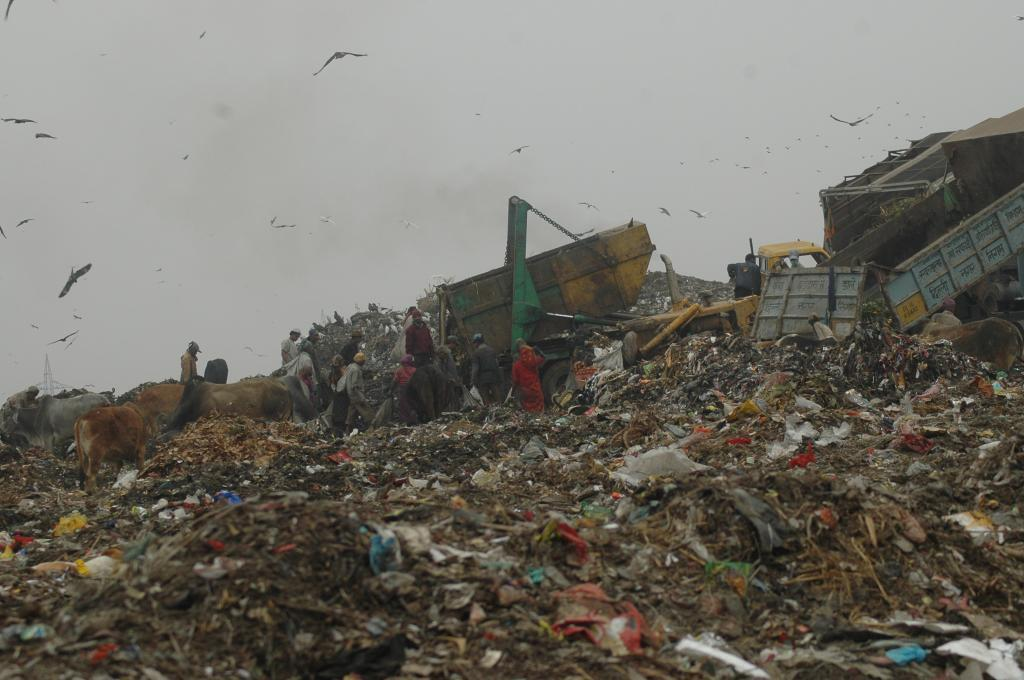

- Waste management is a big problem in our country. Most of the wastes end up in landfills. This leads to following issues like

       1) Increase in landfills
       2) Eutrophication
       3) Consumption of toxic waste by animals
       4) Increase in toxins
       5) Land, water and air pollution
    
    
- We can adopt following approaches to some extent and reduce the waste landing in landfills and make our enironement better.

      1) Studied white papers on waste management
      2) Analysed the components of household waste
      3) Segregated into two classes (Organic and recyclable)
      4) Automated the process by using IOT and machine learning
      5) Reduce toxic waste ending in landfills

### `STEP 1: IMPORT LIBRARIES`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import skimage 
import tensorflow 
import glob
import time 

from tqdm import tqdm

from skimage.io import imshow, imread
from skimage.transform import resize
from skimage.color import rgb2gray, rgba2rgb

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

%matplotlib inline

In [2]:
import numba

from numba import cuda
device = cuda.get_current_device()
device.reset()

In [3]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

**`REFERENCE LINK`** : https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory

In [5]:
# Checking GPU is available or not.

print("GPU  Availability: ", tensorflow.test.is_gpu_available())

GPU  Availability:  True


`RuntimeError: Physical devices cannot be modified after being initialized`

### `STEP 2: IMPORT DATASET / DATA PREPROCESSING`

In [6]:
import os
path = os.getcwd()

In [7]:
# Loading Dataset 

train_data_organic  = glob.glob(path + '\\DATASET\\TRAIN\\O\\*.jpg')
train_data_recycled = glob.glob(path + '\\DATASET\\TRAIN\\R\\*.jpg')

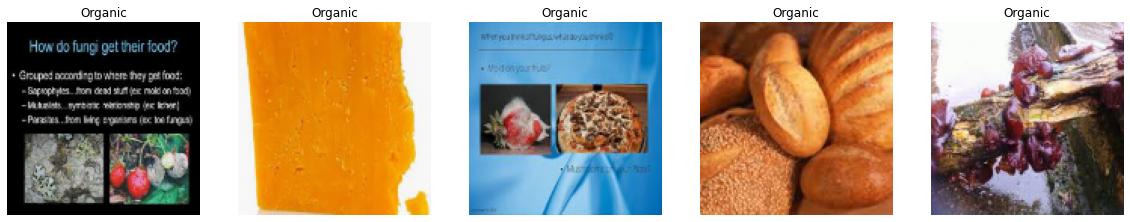

In [8]:
# Viewing Images - Organic 

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in range(0, 5):
    rand = np.random.randint(100)
    img  = imread(train_data_organic[rand])
    img  = resize(img, (128,128))
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title("Organic")

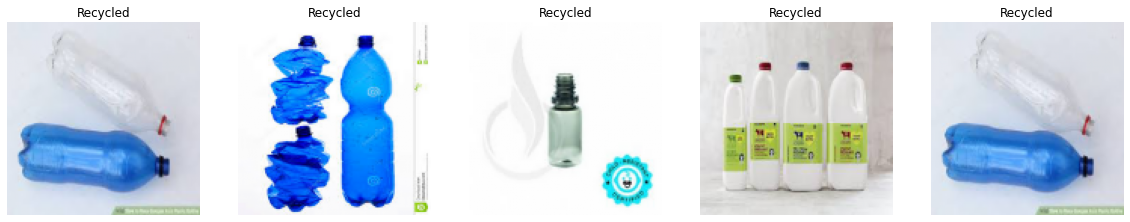

In [9]:
# Viewing Images - Recycled

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in range(0, 5):
    rand = np.random.randint(100)
    img  = imread(train_data_recycled[rand])
    img  = resize(img, (128,128))
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title("Recycled")

In [ ]:
image = imread(train_data_organic[0])
image.shape

In [ ]:
image.shape[2]

In [ ]:
Image = []
Label = []

for i in tqdm(train_data_organic):
    img = imread(i)
    if img.shape[2] == 4:
        img = rgb2gray(rgba2rgb(img))
        img = resize(img, (128,128))
        Image.append(img)
        Label.append(0)
    elif img.shape[2] == 3:
        img = rgb2gray(img)
        img = resize(img, (128,128))
        Image.append(img)
        Label.append(0)

In [10]:
Image = []
Label = []

for i in tqdm(train_data_organic):
    img = imread(i)
    img = resize(img, (128,128,3))
    #img = rgb2gray(img)
    Image.append(img)
    Label.append(0)
    

for i in tqdm(train_data_recycled):
    img = imread(i)
    img = resize(img, (128,128,3))
    #img = rgb2gray(img)
    Image.append(img)
    Label.append(1)
    
Image = np.array(Image)
Label = np.array(Label)

100%|██████████| 9999/9999 [01:14<00:00, 133.38it/s]


 1%|          | 71/12565 [00:00<00:54, 229.05it/s]<ipython-input-9-15359c5b488b>:6: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img = rgb2gray(img)
 29%|██▉       | 3692/12565 [00:20<00:49, 179.28it/s]<ipython-input-9-15359c5b488b>:6: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img = rgb2gray(img)
 69%|██████▉   | 8639/12565 [00:49<00:22, 172.82it/s]

In [11]:
# Checking shape of Image and Label arrays

Image.shape, Label.shape

((22564, 128, 128, 3), (22564,))

In [12]:
# Shuffle the images as organic and recycled are appended.

Image, Label = shuffle(Image, Label, random_state = 42)

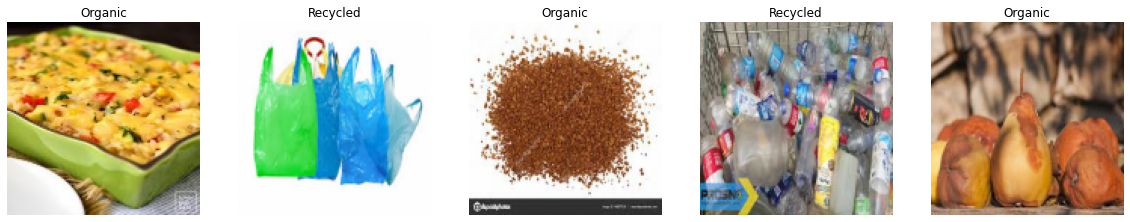

In [13]:
# Viewing Images - After Shuffle 

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in range(0,5):
    rand = np.random.randint(100)
    ax[i].imshow(Image[rand])
    ax[i].axis('off')
    if Label[rand] == 0:
        ax[i].set_title('Organic')
    else:
        ax[i].set_title('Recycled')

### `STEP 3: BUILDING MODEL`

> **`STEP 1: ASSIGNING LABEL & IMAGES TO NEW VARIABLE`**

In [14]:
# Assigning Images and Label to new variable 

X = Image
y = Label

> **`STEP 2: CREATING TRAIN & VALIDATION DATA`**

In [15]:
# Creating Train and Validation 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [16]:
X_train.shape, X_val.shape

((18051, 128, 128, 3), (4513, 128, 128, 3))

> **`STEP 3: DATA AUGMENTATION`**

In [17]:
# Image Augmentation

train_datagen = ImageDataGenerator(rescale=1.0/255,
                             rotation_range=30,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             fill_mode='nearest',
                             shear_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)

validation_datgen = ImageDataGenerator(rescale=1.0/255)

In [18]:
# Fitting data generators to train and valid in batches

train_datagen.fit(X_train)
train_gen = train_datagen.flow(X_train, y_train, batch_size = 128, shuffle = False)

validation_datgen.fit(X_val)
valid_gen = validation_datgen.flow(X_val, y_val, batch_size = 128, shuffle = False)

**`ERROR - Converting image into grey scale we get below error`**

`ValueError: Input to `.fit()` should have rank 4. Got array with shape: (18051, 128, 128)`

> **`STEP 4: BUILDING MODEL`**

In [23]:
# Creating Model Skeleton
model = Sequential()

# Defining Input Layer
model.add(InputLayer(input_shape = (128, 128, 3)))

# Adding Convolution Layer, BatchNormlization and Maxpooling
model.add(Conv2D(filters = 32,  kernel_size  = (3, 3), strides=(2, 2), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(filters = 64,  kernel_size  = (3, 3), strides=(2, 2), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(filters = 128, kernel_size  = (3, 3), strides=(2, 2), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))


# Add Flatten Layer
model.add(Flatten())

# Add Fully Connected Layer
model.add(Dense(units = 256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Adding Output Layer
model.add(Dense(units = 1, activation = 'sigmoid'))

# Summary 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 63, 63, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 63, 63, 32)        128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 31, 31, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 128)      

**`ERROR`** 

`ResourceExhaustedError: OOM when allocating tensor with shape[476288,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul]`

     1) We can include MaxPooling at each layer to reduce the dimensions.
     2) Use gray scale as there will be only 1 channel.
     3) Use Dropout.
     4) You can also reduce the size of the image.
     5) Reduce numer of layers.
     6) Increase the strides.
     
     
**`Reference Link`** : https://stackoverflow.com/questions/59394947/how-to-fix-resourceexhaustederror-oom-when-allocating-tensor

> **`STEP 5: COMPILE MODEL`**

In [24]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

> **`STEP 6: DEFINING CALLBACKS - LR / EARLYSTOPPING / MODLECHECKPOINT`**

In [25]:
filepath = 'best_weights.hdf5'

learning_rate = ReduceLROnPlateau(monitor='val_accuracy', 
                                  patience = 2, 
                                  verbose = 1, 
                                  factor = 0.1, 
                                  min_delta = 0.000001)

earlystopping = EarlyStopping(monitor='val_accuracy', 
                              mode='max', 
                              verbose = 1, 
                              patience = 5)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor='val_accuracy', 
                                verbose=1, 
                                save_best_only=True, 
                                mode='max')

callbacks_list = [learning_rate, earlystopping, checkpoint]                           

> **`STEP 7: MODEL TRAINING`**

In [26]:
model_history = model.fit(train_gen, 
                          validation_data=valid_gen,
                          batch_size = 128,
                          epochs = 50, 
                          verbose = 1, 
                          callbacks = callbacks_list)

Epoch 1/50
142/142 [==============================] - ETA: 0s - loss: 0.5200 - accuracy: 0.7775
Epoch 00001: val_accuracy improved from -inf to 0.44139, saving model to best_weights.hdf5
142/142 [==============================] - 62s 437ms/step - loss: 0.5200 - accuracy: 0.7775 - val_loss: 1.7217 - val_accuracy: 0.4414
Epoch 2/50
142/142 [==============================] - ETA: 0s - loss: 0.4639 - accuracy: 0.7907
Epoch 00002: val_accuracy did not improve from 0.44139
142/142 [==============================] - 66s 461ms/step - loss: 0.4639 - accuracy: 0.7907 - val_loss: 1.1465 - val_accuracy: 0.4414
Epoch 3/50
142/142 [==============================] - ETA: 0s - loss: 0.4406 - accuracy: 0.8002
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00003: val_accuracy did not improve from 0.44139
142/142 [==============================] - 67s 471ms/step - loss: 0.4406 - accuracy: 0.8002 - val_loss: 1.6412 - val_accuracy: 0.4414
Epoch 4/50
142/142 [=======

`ResourceExhaustedError:  OOM when allocating tensor with shape[128,64,124,124] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc`